## Elo Merchant Category Recommendation - User Loyalty Prediction

### Hsing-Yi Wang, Yi-Ying Peng

##### Mar. 14, 2019

## Introduction, Motivation

## Import Library

In [ ]:
# install.packages("dummies")
# install.packages("fastDummies")
# install.packages('tidyverse')
# install.packages("RColorBrewer")

In [30]:
# library(readr)
# library(dplyr)
# library(dummies)
# library(fastDummies)
# library(tidyverse)
# library("RColorBrewer")
# library(repr)
library(lubridate)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



## Load Data

In [6]:
# historical_transactions <- read_csv("/Users/eve7947/Downloads/elo-merchant-category-recommendation/historical_transactions.csv")
# merchants <- read_csv("/Users/eve7947/Downloads/elo-merchant-category-recommendation/merchants.csv")
# new_merchant_transactions <- read_csv("/Users/eve7947/Downloads/elo-merchant-category-recommendation/new_merchant_transactions.csv")
# sample_submission <- read_csv("/Users/eve7947/Downloads/elo-merchant-category-recommendation/sample_submission.csv")
# test <- read_csv("/Users/eve7947/Downloads/elo-merchant-category-recommendation/test.csv")
# train <- read_csv("/Users/eve7947/Downloads/elo-merchant-category-recommendation/train.csv")

## Describe Data

### Training Data

Contains the card_id used for training, and loyalty score which is our dependent variables. 

In [29]:
glimpse(train)

Observations: 201,917
Variables: 6
$ first_active_month <chr> "2017-06", "2017-01", "2016-08", "2017-09", "201...
$ card_id            <chr> "C_ID_92a2005557", "C_ID_3d0044924f", "C_ID_d639...
$ feature_1          <int> 5, 4, 2, 4, 1, 4, 3, 3, 2, 2, 5, 2, 5, 2, 3, 2, ...
$ feature_2          <int> 2, 1, 2, 3, 3, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, ...
$ feature_3          <int> 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, ...
$ target             <dbl> -0.82028260, 0.39291325, 0.68805599, 0.14249520,...


In [10]:
sapply(train,class)

first_active_month            card_id          feature_1          feature_2 
       "character"        "character"          "integer"          "integer" 
         feature_3             target 
         "integer"          "numeric"

In [7]:
summary(train)

 first_active_month   card_id            feature_1       feature_2    
 Length:201917      Length:201917      Min.   :1.000   Min.   :1.000  
 Class :character   Class :character   1st Qu.:2.000   1st Qu.:1.000  
 Mode  :character   Mode  :character   Median :3.000   Median :2.000  
                                       Mean   :3.105   Mean   :1.745  
                                       3rd Qu.:4.000   3rd Qu.:2.000  
                                       Max.   :5.000   Max.   :3.000  
   feature_3          target         
 Min.   :0.0000   Min.   :-33.21928  
 1st Qu.:0.0000   1st Qu.: -0.88311  
 Median :1.0000   Median : -0.02344  
 Mean   :0.5656   Mean   : -0.39364  
 3rd Qu.:1.0000   3rd Qu.:  0.76545  
 Max.   :1.0000   Max.   : 17.96507  

In [16]:
options(repr.plot.width=8, repr.plot.height=3)

Warning message in brewer.pal(n = 2, name = "Set3"):
“minimal value for n is 3, returning requested palette with 3 different levels
”

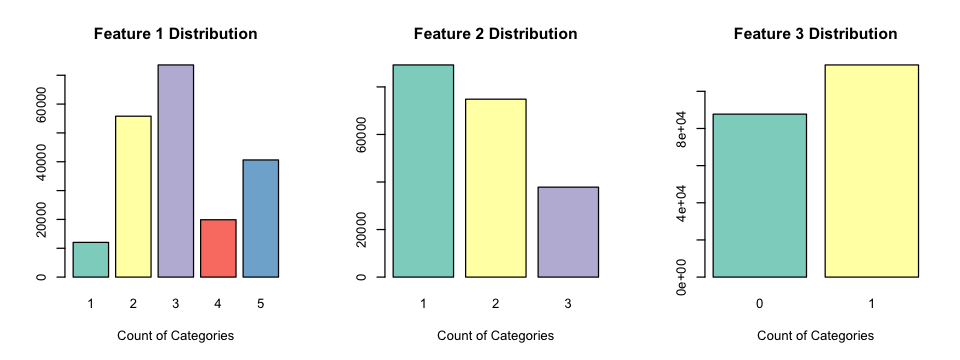

In [26]:
par(mfrow=c(1,3))
counts1 <- table(train$feature_1)
counts2 <- table(train$feature_2)
counts3 <- table(train$feature_3)
barplot(counts1, col=brewer.pal(n=5, name="Set3"), main="Feature 1 Distribution", xlab="Count of Categories")
barplot(counts2, col=brewer.pal(n=3, name="Set3"), main="Feature 2 Distribution", xlab="Count of Categories")
barplot(counts3, col=brewer.pal(n=2, name="Set3"), main="Feature 3 Distribution", xlab="Count of Categories")

In [28]:
hist(train$first_active_month)

ERROR: Error in hist.default(train$first_active_month): 'x' must be numeric


In [31]:
options(repr.plot.width=8, repr.plot.height=3)

Warning message:
“Removed 1 rows containing non-finite values (stat_count).”

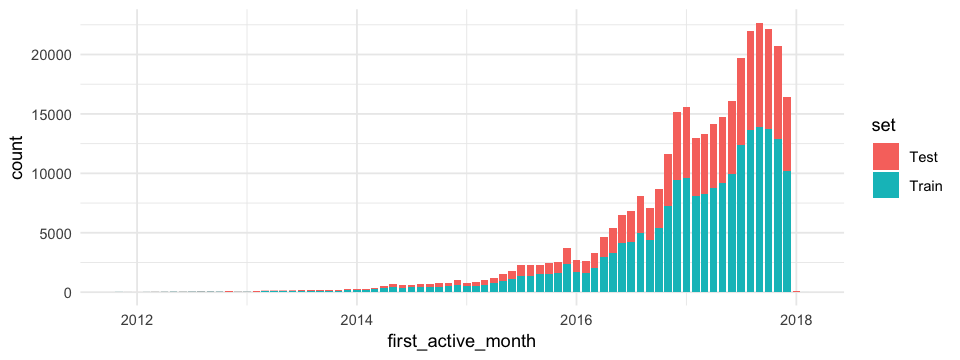

In [33]:
train %>% 
bind_rows(test) %>% 
mutate(set = factor(if_else(is.na(target), "Test", "Train")),
 first_active_month = ymd(first_active_month, truncated = 1)) %>% 
ggplot(aes(x = first_active_month, fill = set)) + geom_bar() + theme_minimal()

### Testing Data

Contains the card_id used for prediction.

### History

Contains up to 3 months' worth of transactions for every card.

### New Merchant Period

Contains the transactions at new merchants (merchant_ids that this particular card_id has not yet visited) over a period of two months.

### Merchant

Contains aggregate information for each merchant_id

## Check Data Quality

## Integration of  Data

## Linear Regression